In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
import decoupler as dc
from statsmodels.stats.multitest import multipletests

np.random.seed(42)
sc.settings.n_jobs = 8
sc.set_figure_params(dpi=100, dpi_save=600, frameon=False, figsize=(5,5))
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['axes.grid'] = False
plt.rcParams["font.family"] = "Arial"
%config InlineBackend.figure_format = 'retina'

In [2]:
from adjustText import adjust_text
from delnx.pp._get_de_genes import get_de_genes


class VolcanoPlot:
    """Static volcano plot using matplotlib."""

    DEFAULT_COLOR_LEGEND_TITLE = "-log10(p-value)"
    DEFAULT_SAVE_PREFIX = "volcanoplot"

    def __init__(
        self,
        df: pd.DataFrame,
        x: str = "coef",
        y: str = "-log10(pval)",
        thresh: dict[str, float] | None = None,
        color_legend_title: str | None = None,
        ax: plt.Axes | None = None,
        figsize: tuple[float, float] = (8, 6),
        save_path: str | None = None,
    ):
        self.df = df.copy()
        self.x = x
        self.y = y
        self.thresh = thresh or {}
        self.color_legend_title = color_legend_title or self.DEFAULT_COLOR_LEGEND_TITLE
        self.save_path = save_path
        self.figsize = figsize
        self.ax = ax

        # Compute -log10(pval) if needed and y is set to that
        if self.y == "-log10(pval)" and "-log10(pval)" not in self.df.columns:
            self.df["-log10(pval)"] = -np.log10(self.df["pval"])

        # Default color map
        self.color_map = {
            "NS": "#d1d5db",  # gray-300
            "Up": "#ef4444",  # red-500
            "Down": "#3b82f6",  # blue-500
        }

    def style(self, color_map: dict[str, str] | None = None) -> "VolcanoPlot":
        if color_map:
            self.color_map = color_map
        return self

    def make_figure(self) -> "VolcanoPlot":
        if self.ax is not None:
            self.fig = self.ax.figure
        else:
            self.fig, self.ax = plt.subplots(figsize=self.figsize)

        # Plot each significance group
        for label, color in self.color_map.items():
            subset = self.df[self.df["significant"] == label]
            self.ax.scatter(
                subset[self.x],
                subset[self.y],
                c=color,
                label=label,
                edgecolor=None,
                linewidth=0,
                s=50,
                alpha=0.5,
            )

        # Threshold lines
        x_thresh = self.thresh.get(self.x, None)
        y_thresh = self.thresh.get(self.y, None)
        if y_thresh is not None:
            self.ax.axhline(y=y_thresh, color="black", linestyle="--", linewidth=1)
        if x_thresh is not None:
            self.ax.axvline(x=x_thresh, color="black", linestyle="--", linewidth=1)
            self.ax.axvline(x=-x_thresh, color="black", linestyle="--", linewidth=1)

        # Labels and grid
        self.ax.set_xlabel(self.x if self.x != "coef" else "Estimated Coefficient")
        self.ax.set_ylabel(self.y if self.y != "-log10(pval)" else "-log10(p-value)")
        self.ax.legend(title=self.color_legend_title)
        self.ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

        return self

    def add_labels(self, top_up: list[str], top_down: list[str]) -> None:
        if self.ax is None:
            raise RuntimeError("Plot must be initialized before adding labels.")
        texts = []
        for feature in top_up + top_down:
            row = self.df[self.df["feature"] == feature].iloc[0]
            texts.append(
                self.ax.text(
                    row[self.x],
                    row[self.y],
                    feature,
                    fontsize=12,
                    ha="right" if row[self.x] > 0 else "left",
                    va="bottom",
                    # bbox={
                    #     "boxstyle": "round,pad=0.3",
                    #     "facecolor": "white",
                    #     "edgecolor": "black",
                    #     "linewidth": 0.5,
                    # },
                )
            )
        adjust_text(
            texts,
            ax=self.ax,
            arrowprops={
                "arrowstyle": "-",
                "color": "gray",
                "lw": 0.5,
            },
        )

    def show(self):
        if self.fig is None:
            self.make_figure()
        plt.show()

    def save(self):
        if self.fig and self.save_path:
            self.fig.savefig(self.save_path, bbox_inches="tight", dpi=300)

    def get_figure(self):
        if self.fig is None:
            self.make_figure()
        return self.fig, self.ax


def volcanoplot(
    df: pd.DataFrame,
    x: str = "coef",
    y: str = "-log10(pval)",
    thresh: dict[str, float] | None = None,
    label_top: int = 0,
    color_legend_title: str | None = None,
    ax: plt.Axes | None = None,
    figsize: tuple[float, float] = (8, 6),
    show: bool | None = True,
    save: str | bool | None = None,
    return_fig: bool = False,
):
    """
    Create a volcano plot using matplotlib.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'coef', 'pval', 'significant', and optionally 'feature'.
    x : str
        Column name for x-axis.
    y : str
        Column name for y-axis.
    thresh : dict[str, float] or None
        Dictionary mapping axis names to threshold values, e.g. {'coef': 1.0, '-log10(pval)': 1.3}.
    label_top : int
        If > 0, label top N up/down genes by effect size.
    color_legend_title : str or None
        Title for the legend. Default: "-log10(p-value)".
    ax : plt.Axes or None
        If provided, use this Axes for plotting instead of creating a new one.
        If None, a new Axes will be created.
    figsize : tuple[float, float]
        Size of the figure in inches. Default: (8, 6).
    show : bool or None
        Whether to display the figure interactively.
    save : str or bool or None
        If str, path to save the image. If True, uses default name.
    return_fig : bool
        Whether to return the matplotlib Figure and Axes.

    Returns
    -------
    VolcanoPlot or tuple[Figure, Axes] or None
    """
    # Check group uniqueness if group column exists
    if "group" in df.columns:
        unique_groups = df["group"].unique()
        if len(unique_groups) > 1:
            raise ValueError(f"Volcano plot expects a single group, but found multiple: {unique_groups}")

    save_path = None
    if isinstance(save, str):
        save_path = save
    elif save is True:
        save_path = f"{VolcanoPlot.DEFAULT_SAVE_PREFIX}.pdf"

    vp = VolcanoPlot(
        df,
        x=x,
        y=y,
        thresh=thresh,
        color_legend_title=color_legend_title,
        figsize=figsize,
        ax=ax,
        save_path=save_path,
    ).make_figure()

    if label_top > 0 and "feature" in df.columns:
        de_genes_dict = get_de_genes(df, top_n=label_top)
        de_genes_dict = de_genes_dict[list(de_genes_dict.keys())[0]]
        top_up, top_down = de_genes_dict["up"], de_genes_dict["down"]
        vp.add_labels(top_up, top_down)

    if save_path:
        vp.save()
    if show:
        vp.show()
    if return_fig:
        return vp.get_figure()

In [3]:
import numpy as np
import jax.numpy as jnp
import jax.random as random
import numpyro as npr
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def ab_model(groupA, groupB=None):
    """
    Bayesian A/B testing model with shared variance.
    If only groupA is passed, model reduces to single group.
    """
    mu_A = npr.sample("mu_A", dist.Normal(0, 10))
    sigma = npr.sample("sigma", dist.HalfCauchy(5))
    
    npr.sample("obs_A", dist.Normal(mu_A, sigma), obs=groupA)
    
    if groupB is not None:
        mu_B = npr.sample("mu_B", dist.Normal(0, 10))
        npr.sample("obs_B", dist.Normal(mu_B, sigma), obs=groupB)

def run_ab_test(groupA, groupB, seed=0, num_samples=2000, num_warmup=1000):
    """
    Run Bayesian A/B testing in NumPyro.
    
    Parameters
    ----------
    groupA : array-like
        Data from group A
    groupB : array-like
        Data from group B
    rng_key : jax.random.PRNGKey
    num_samples : int
        Number of MCMC posterior samples
    num_warmup : int
        Number of warmup steps
    
    Returns
    -------
    results : dict
        Dictionary containing posterior means, posterior probability
        that mu_B > mu_A, and samples.
    """
    rng_key=random.PRNGKey(seed)
    kernel = NUTS(ab_model)
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
    mcmc.run(rng_key, jnp.array(groupA), jnp.array(groupB))
    samples = mcmc.get_samples()
    
    mu_A_samples = samples["mu_A"]
    mu_B_samples = samples["mu_B"]
    
    # Posterior probability that B > A
    prob_B_greater_A = jnp.mean(mu_B_samples > mu_A_samples)
    
    results = {
        "mu_A_mean": float(jnp.mean(mu_A_samples)),
        "mu_B_mean": float(jnp.mean(mu_B_samples)),
        "prob_B_greater_A": float(prob_B_greater_A),
        "samples": samples
    }
    return results

In [4]:
def stack_vln(adata:sc.AnnData, markers:list, groupby:str, layer:str, figsize:tuple=(5,8), pad:float=-0.5, **kwds):
    fig, ax = plt.subplots(len(markers),1, figsize=figsize)
    for i,g in enumerate(markers):
        sc.pl.violin(adata, keys=g, groupby=groupby,layer=layer, ax=ax[i], show=False, **kwds)
        ax[i].grid(False)
        ax[i].set_ylim(0, 5)
        if i+1 < len(markers):
            ax[i].set_xlabel('')
            ax[i].set_xticks([])
    fig.tight_layout(pad=pad)
    return fig, ax

In [5]:
sk_color = {
 'Atf3': '#a9a9a9',
 'NF1': '#ffd900',
 'NF2': '#ff8c00',
 'NF3': '#ff4040',
 'NP': '#67cd00',
 'PEP1': '#87cefa',
 'PEP2': '#1c86ee',
 'SST': '#104e8b',
 'cLTMR1': '#98f5ff',
 'p_cLTMR2': '#00ced1',
 'NFs': '#104e8b',
 'Nociceptors': '#ff8c00',
 }

In [6]:
import delnx as dx

In [7]:
adata_noci = sc.read_h5ad('/Volumes/T5/Rnase4_10x/rnase4_adata_noci.h5ad')
adata_noci.obs['Nociceptors'] = 'Nociceptors'

In [8]:
adata_noci = adata_noci[adata_noci.obs.ct_cleaned != 'cLTMR1']

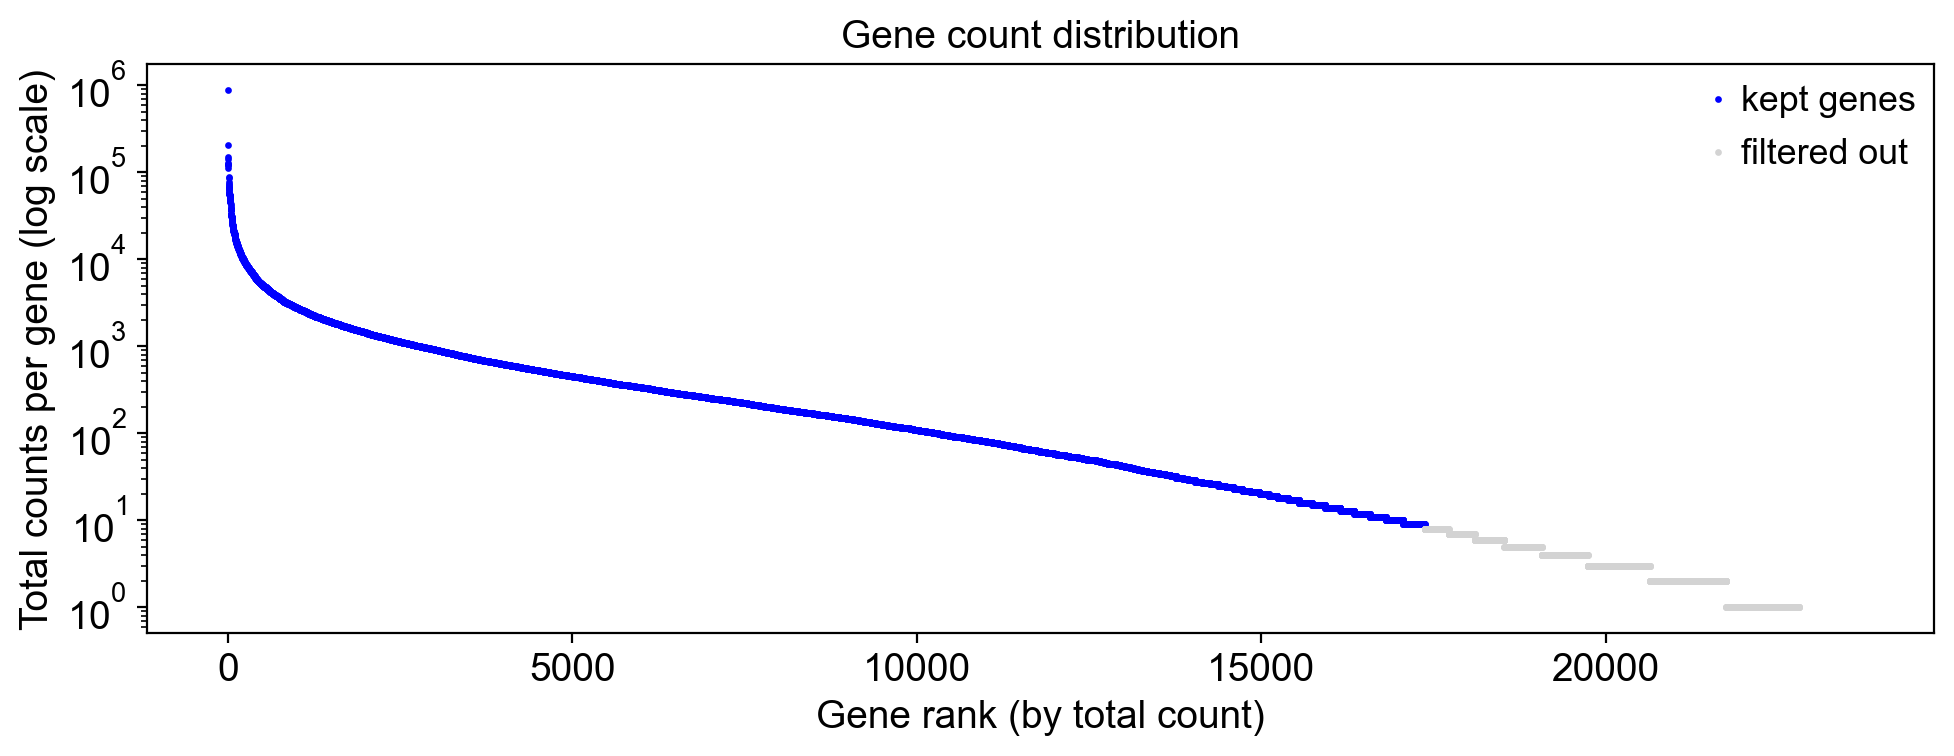

In [9]:
keep_mask = dx.pp.filter_genes(adata_noci, mode="quantile", quantile=0.25)
dx.pl.plot_filtered_genes(adata_noci, keep_mask=keep_mask, layer="counts")

In [10]:
adata_noci = adata_noci[:, keep_mask].copy()
adata_noci = adata_noci[adata_noci.obs.ct_cleaned != 'cLTMR1'].copy()

In [11]:
adata_pb = dx.pp.pseudobulk(
    adata_noci,
    sample_key="sample_id",  # Sample key for pseudobulk aggregation (the biological replicate)
    group_key="ct_cleaned",  # Group key for pseudobulk aggregation
    n_pseudoreps=5,  # Optionally, the data can be split into multiple pseudoreplicates. This can be useful if the number of actual biological replicates is low.
    layer="counts",  # Layer to use for pseudobulk aggregation, e.g. "counts" or None for adata.X
    mode="sum",
)
dc.pp.filter_by_expr(adata=adata_pb, group='Conditions', min_count=10, min_total_count=350, large_n=15, min_prop=0.7)
dc.pp.filter_by_prop(adata=adata_pb, min_prop=0.2, min_smpls=15)

In [12]:
# Compute size factors
dx.pp.size_factors(adata_pb, method="ratio")

# Estimate dispersion parameters
dx.pp.dispersion(adata_pb, size_factor_key="size_factors", method="deseq2")

INFO:2025-12-18 16:01:18,313:jax._src.xla_bridge:752: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/pax/miniconda3/envs/rnase4_10x/lib/python3.11/site-packages/jaxlib/../../../libtpu.so' (no such file), '/Users/pax/miniconda3/envs/rnase4_10x/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-12-18 16:01:18 | [INFO] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/pax/miniconda3/envs/rnase4_10x/lib/python3.11/site-packages/jaxlib/../../../libtpu.so' (no such file), '/Users/pax/miniconda3/envs/rnase4_10x/b

INFO     Fitting initial dispersions                                                                               


100%|██████████| 3/3 [00:09<00:00,  3.00s/it]

INFO     Fitting dispersion trend curve                                                                            


INFO     Fitting MAP dispersions                                                                                   


/Users/pax/miniconda3/envs/rnase4_10x/lib/python3.11/site-packages/delnx/models/_models.py:1268: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  return self.fit_parametric_dispersion_trend(dispersions, normed_means)
100%|██████████| 3/3 [00:02<00:00,  1.00it/s]


In [13]:
# Run differential expression analysis
results = dx.tl.de(
    adata_pb,
    condition_key='Conditions',
    group_key='ct_cleaned',
    mode="all_vs_ref",
    reference="WT",
    method="negbinom",
    size_factor_key="size_factors",
    dispersion_key="dispersions",
    n_cpus=-1,
    verbose=True
)

INFO     Inferred data type: counts                                                                                
INFO     Running DE for group: NP                                                                                  
INFO     Using specified data type: counts                                                                         
INFO     Testing cKO-PR vs WT                                                                                      
INFO     Running DE for 4175 features                                                                              


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

INFO     Running DE for group: PEP1                                                                                
INFO     Using specified data type: counts                                                                         
INFO     Testing cKO-PR vs WT                                                                                      
INFO     Running DE for 4175 features                                                                              



100%|██████████| 3/3 [00:00<00:00, 13.70it/s]

INFO     Running DE for group: PEP2                                                                                
INFO     Using specified data type: counts                                                                         
INFO     Testing cKO-PR vs WT                                                                                      
INFO     Running DE for 4175 features                                                                              



100%|██████████| 3/3 [00:00<00:00,  7.85it/s]

INFO     Running DE for group: SST                                                                                 
INFO     Using specified data type: counts                                                                         
INFO     Testing cKO-PR vs WT                                                                                      
INFO     Running DE for 4175 features                                                                              



100%|██████████| 3/3 [00:00<00:00,  6.75it/s]

INFO     Running DE for group: p_cLTMR2                                                                            
INFO     Using specified data type: counts                                                                         
INFO     Testing cKO-PR vs WT                                                                                      
INFO     Running DE for 4175 features                                                                              



100%|██████████| 3/3 [00:00<00:00, 10.53it/s]


In [14]:
results = results.drop_duplicates(subset=["group", "feature"], keep="first")
results = results[results["log2fc"].abs() < 10]
dx.pp.label_de_genes(results, coef_thresh=0.25, pval_thresh=0.05, auc_thresh=0)

In [ ]:
results.to_excel('./tables/11_pseudobulk_pydeseq2_cKO-PR_vs_WT_by_ct_deg.xlsx', index=False)
results[results.pval < 0.05].reset_index(drop=True).to_excel('./tables/11_pseudobulk_pydeseq2_cKO-PR_vs_WT_by_ct_deg_filtered.xlsx', index=False)

2025-11-18 11:16:32 | [INFO] maxp pruned
2025-11-18 11:16:32 | [INFO] LTSH dropped
2025-11-18 11:16:32 | [INFO] cmap pruned
2025-11-18 11:16:32 | [INFO] kern dropped
2025-11-18 11:16:32 | [INFO] post pruned
2025-11-18 11:16:32 | [INFO] PCLT dropped
2025-11-18 11:16:32 | [INFO] JSTF dropped
2025-11-18 11:16:32 | [INFO] DSIG dropped
2025-11-18 11:16:32 | [INFO] GPOS pruned
2025-11-18 11:16:32 | [INFO] GSUB pruned
2025-11-18 11:16:32 | [INFO] glyf pruned
2025-11-18 11:16:32 | [INFO] Added gid0 to subset
2025-11-18 11:16:32 | [INFO] Added first four glyphs to subset
2025-11-18 11:16:32 | [INFO] Closing glyph list over 'GSUB': 65 glyphs before
2025-11-18 11:16:32 | [INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'Z', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period',

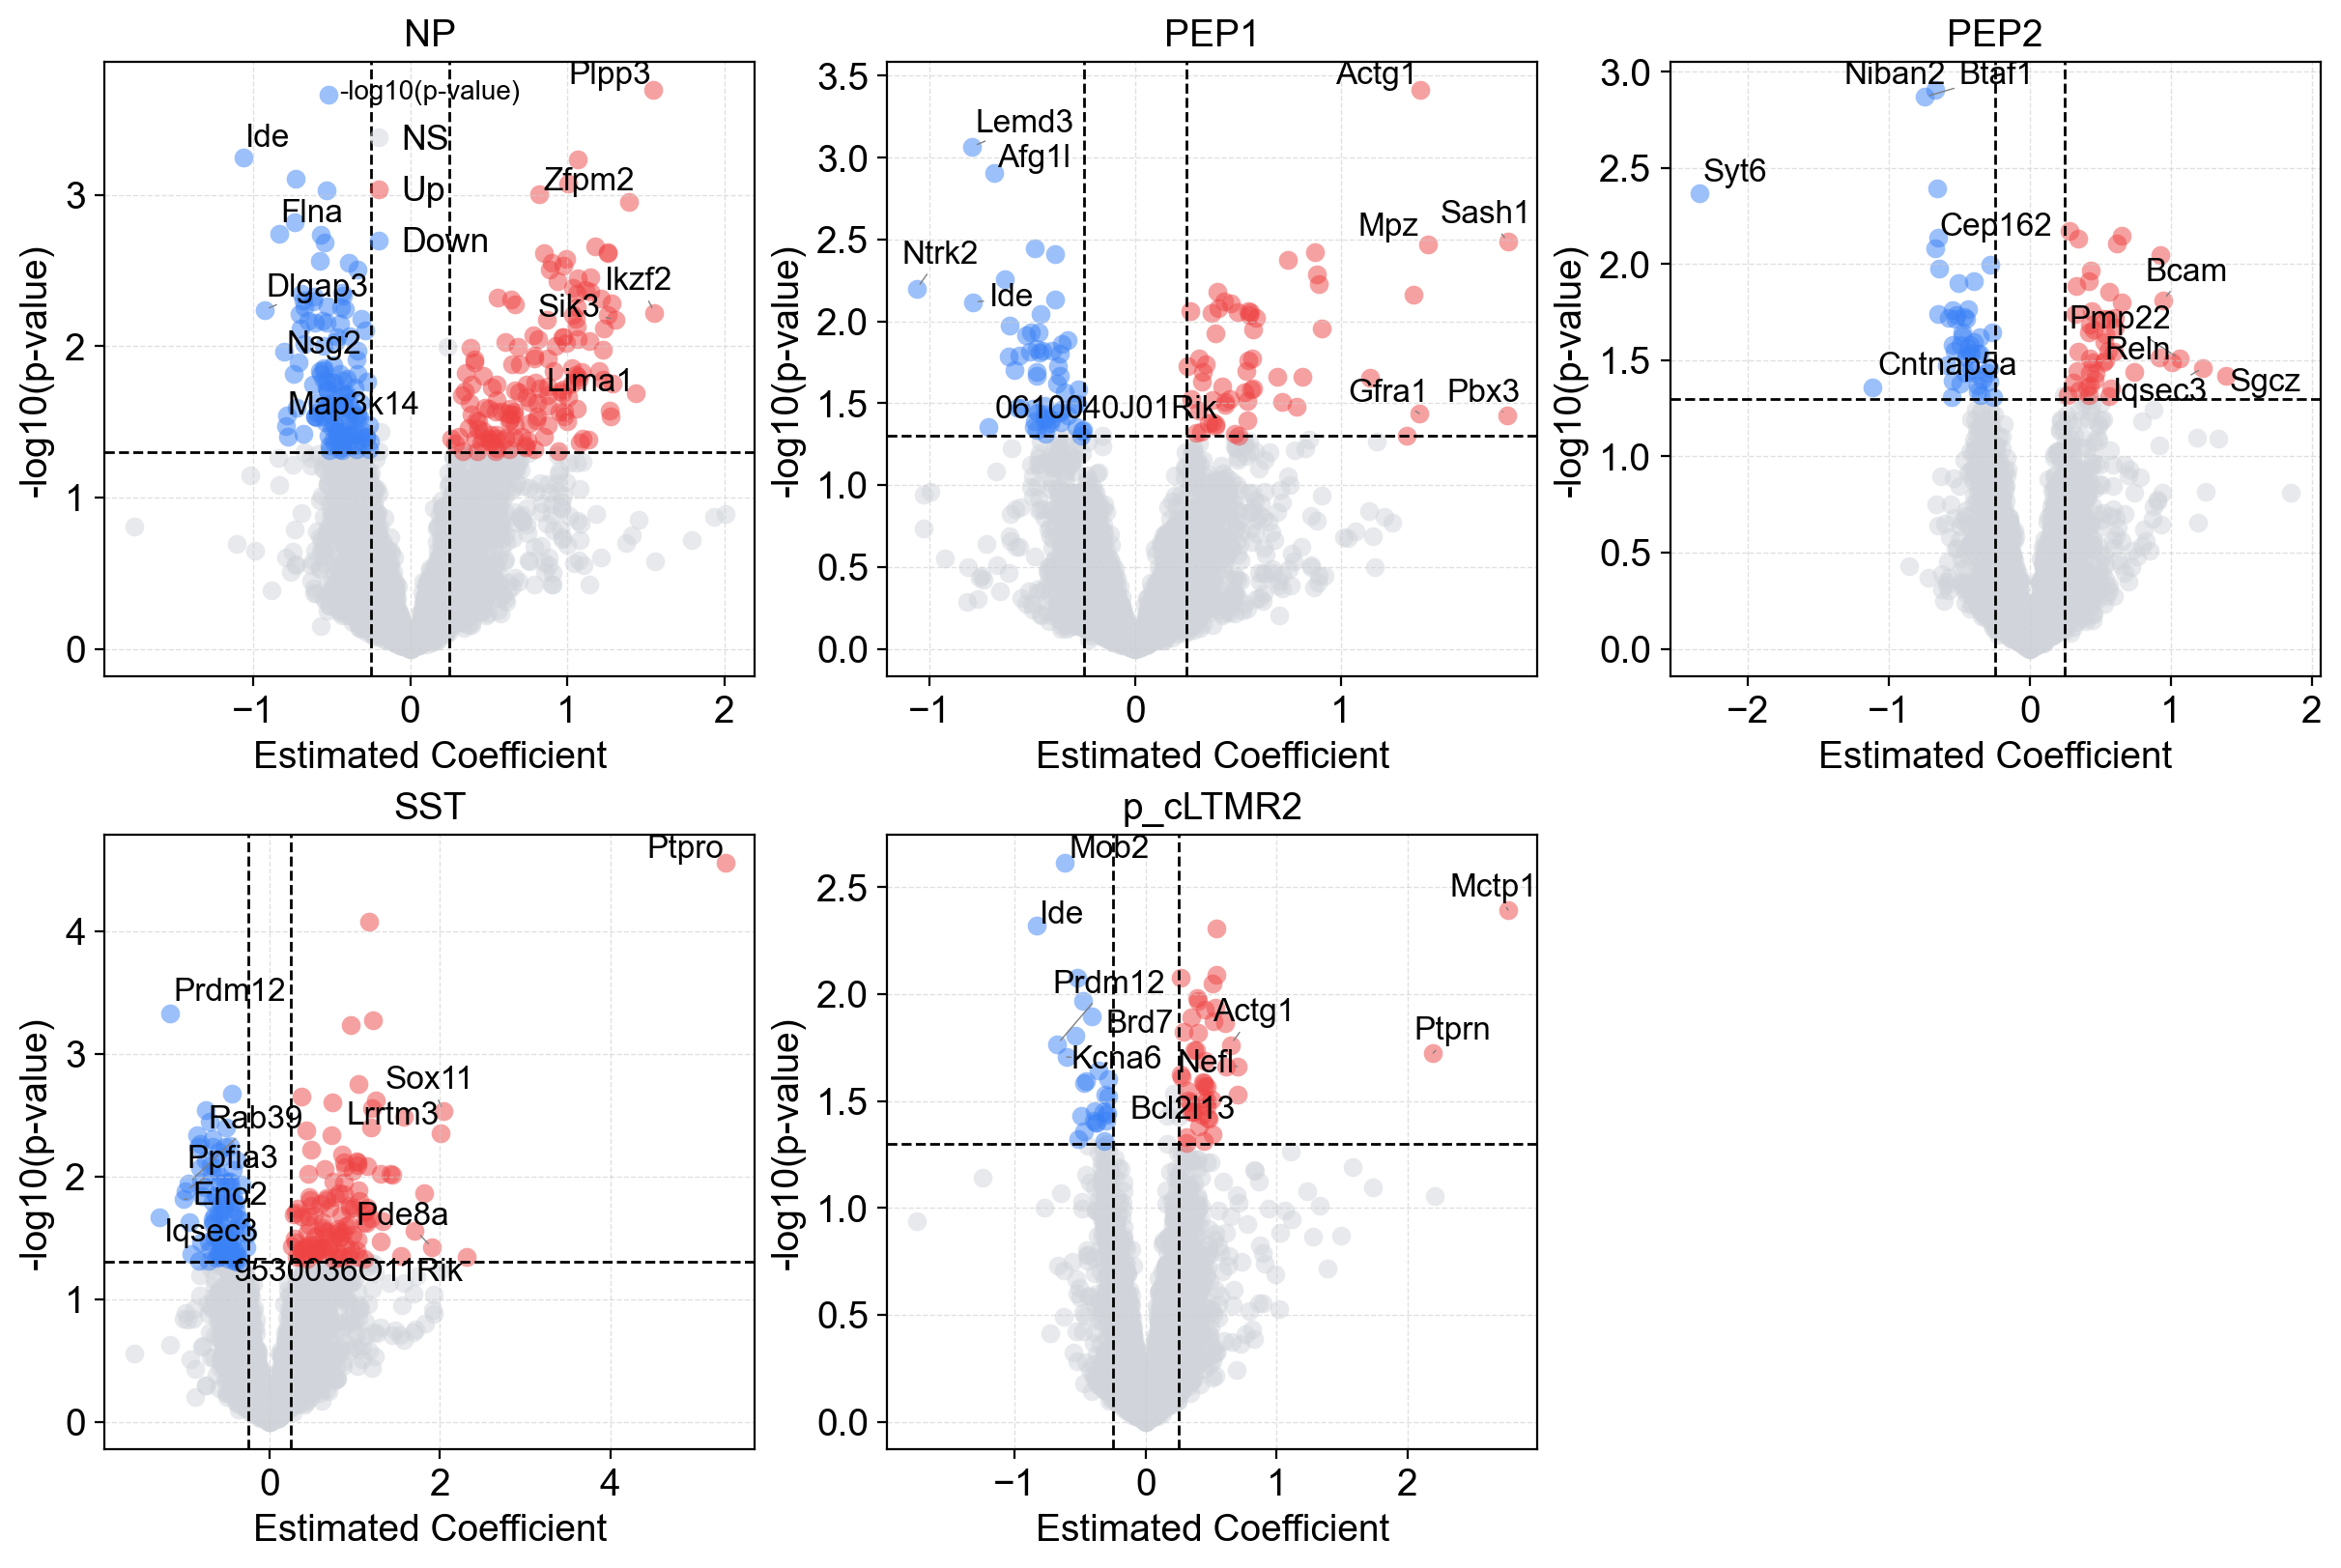

In [ ]:
# Select groups to show
groups_to_plot = results.group.unique()

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), constrained_layout=True)
axs = axs.flatten()

for i, group in enumerate(groups_to_plot):
    ax = axs[i]
    de_df = results[results["group"] == group].copy()
    volcanoplot(
        de_df,
        thresh={"coef": 0.25, "-log10(pval)": -np.log10(0.05)},
        label_top=5,
        ax=ax,
        show=False,
    )
    ax.set_title(group)
    if i != 0:
        ax.get_legend().remove()
    # ax.grid(False)
# Remove empty axes if any
for j in range(len(groups_to_plot), len(axs)):
    fig.delaxes(axs[j])

# Add legend once (optional)
handles, labels = axs[0].get_legend_handles_labels()

plt.savefig(f'./figures/11_10x_volcano_cKO_vs_ctr_deg_by_ct.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [19]:
top_up_per_group = (
    results[results["significant"] == "Up"]  # only upregulated genes
    .drop_duplicates(subset=["group", "feature"], keep="first")  # remove group-feature duplicates
    .sort_values(["group", "coef"], ascending=[True, False])  # sort by group and descending coef
)
marker_dict = top_up_per_group[["feature", "group"]].groupby("group")["feature"].apply(list).to_dict()

2025-10-17 13:29:05 | [INFO] maxp pruned
2025-10-17 13:29:05 | [INFO] LTSH dropped
2025-10-17 13:29:05 | [INFO] cmap pruned
2025-10-17 13:29:05 | [INFO] kern dropped
2025-10-17 13:29:05 | [INFO] post pruned
2025-10-17 13:29:05 | [INFO] PCLT dropped
2025-10-17 13:29:05 | [INFO] JSTF dropped
2025-10-17 13:29:05 | [INFO] DSIG dropped
2025-10-17 13:29:05 | [INFO] GPOS pruned
2025-10-17 13:29:05 | [INFO] GSUB pruned
2025-10-17 13:29:05 | [INFO] glyf pruned
2025-10-17 13:29:05 | [INFO] Added gid0 to subset
2025-10-17 13:29:05 | [INFO] Added first four glyphs to subset
2025-10-17 13:29:05 | [INFO] Closing glyph list over 'GSUB': 20 glyphs before
2025-10-17 13:29:05 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'd', 'e', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't', 'u', 'x', 'y']
2025-10-17 13:29:05 | [INFO] Glyph IDs:   [0, 1, 2, 3, 38, 40, 71, 72, 74, 76, 79, 81, 82, 83, 85, 86, 87, 88, 91, 92]
2025-10-17 13:29:05 | [INFO] Closed glyph list over 'GSUB': 20

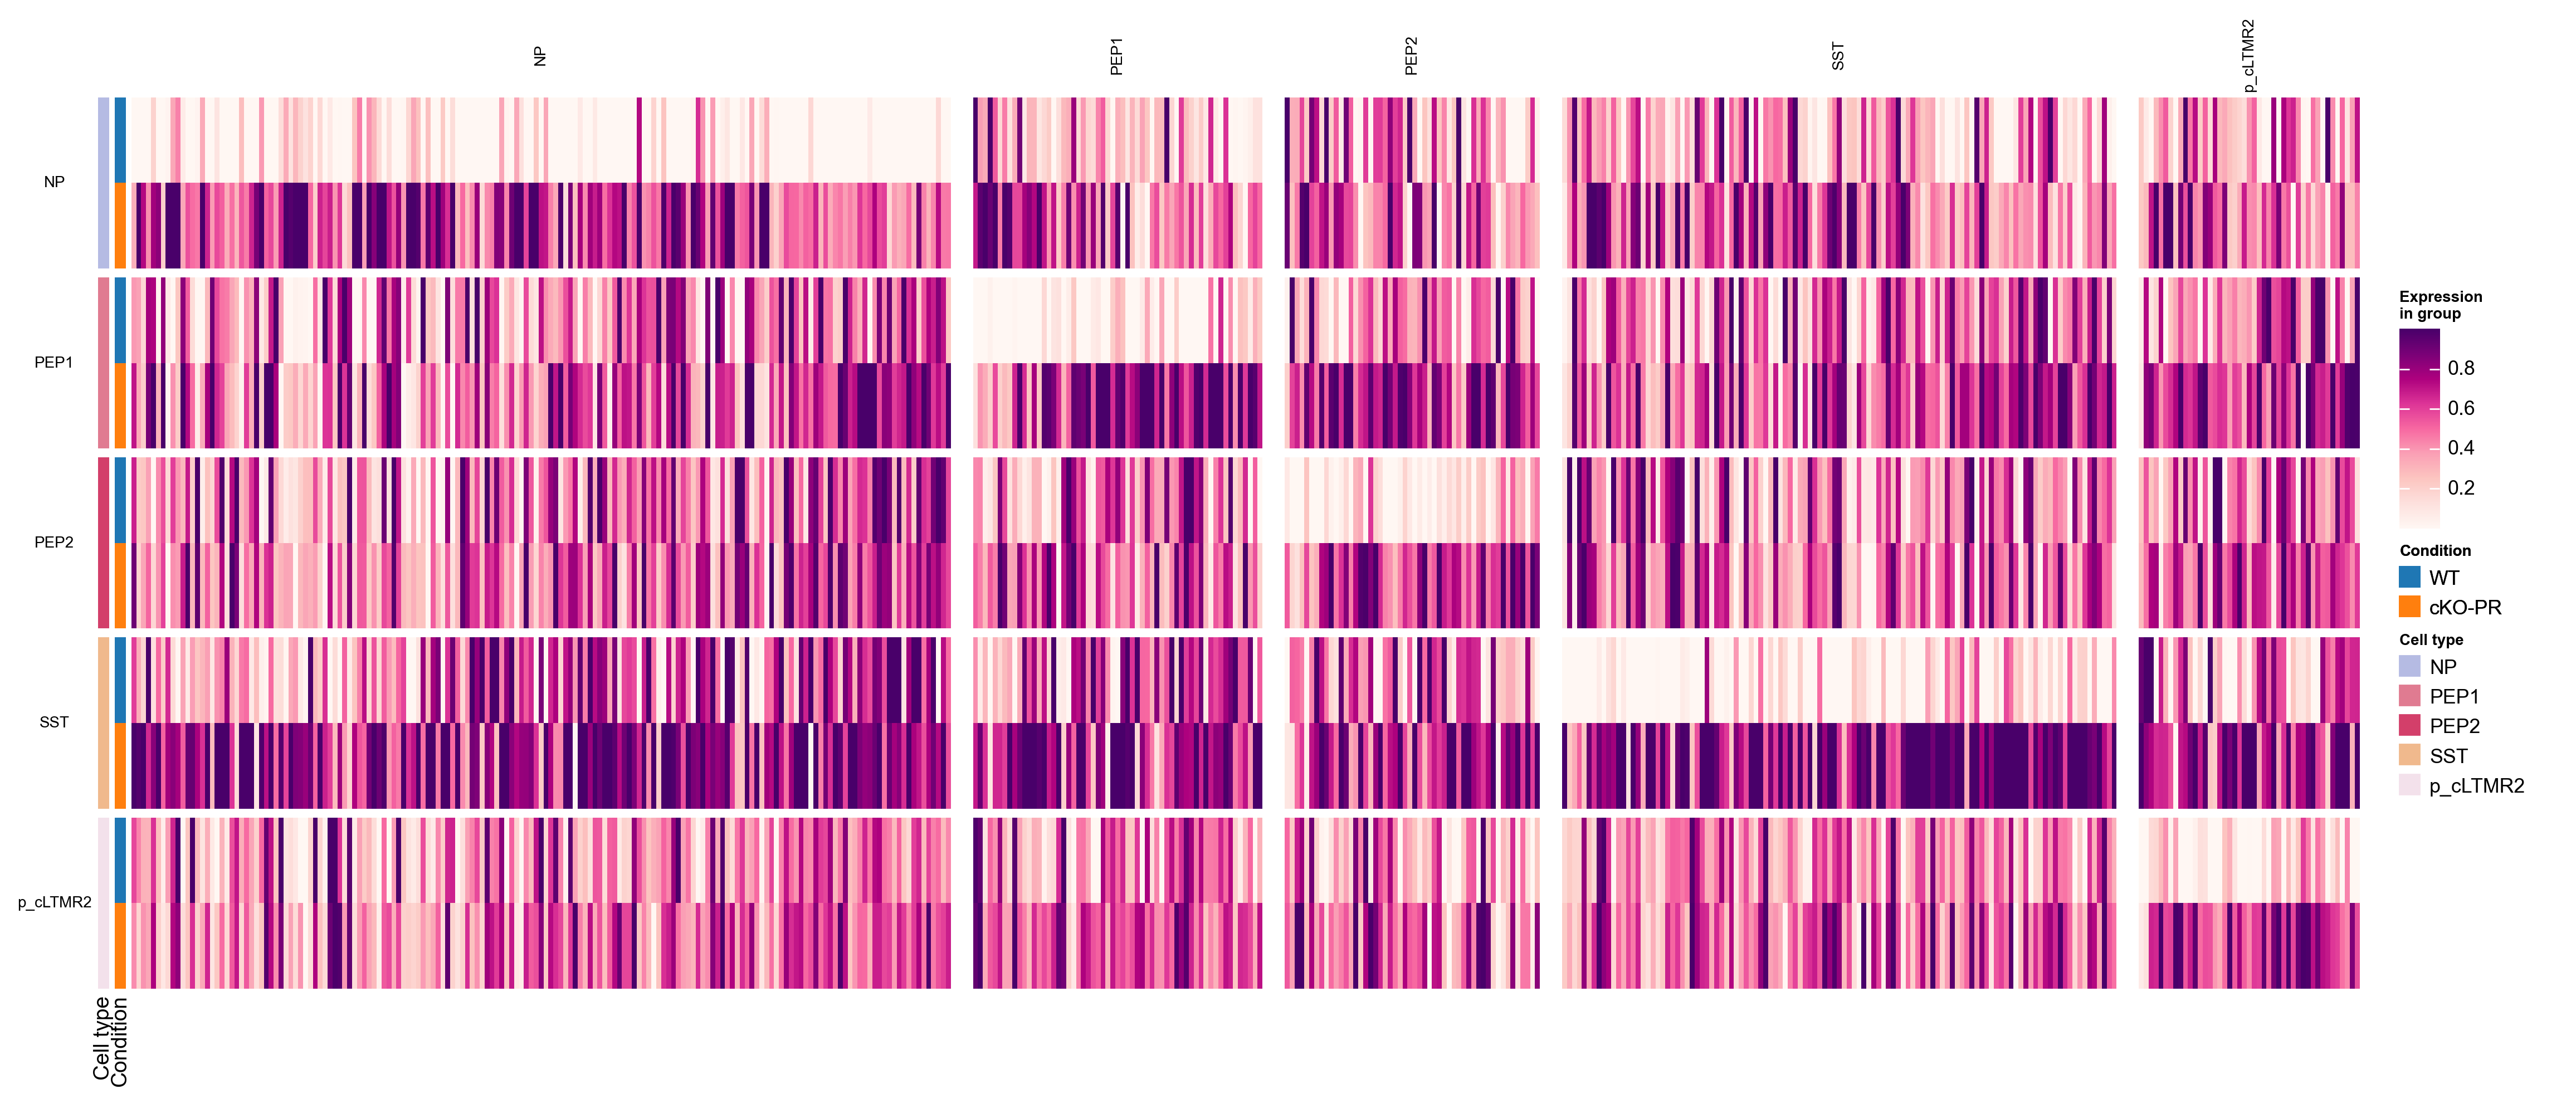

In [ ]:
dx.pl.matrixplot(
    adata_noci,
    markers=marker_dict,
    groupby=['ct_cleaned', 'Conditions'],
    group_names=["Cell type", "Condition"],
    row_grouping=['ct_cleaned'],
    column_grouping=True,
    cmap="RdPu",
    scale=True,
    width=20,
    height=8,
    show_legends=True,
    show_column_names=True,
    show_row_names=True,
    save='./figures/11_10x_heatmap_pseudobulk_UP_markers_by_ct.pdf'
)

In [14]:
# common_up_genes = results[(results.significant == 'Up') & (results.test_condition == 'cKO-PR')].feature.value_counts().loc[lambda x: x > 2].index.tolist()
# common_up_genes

In [34]:
common_up_genes = results[(results.significant == 'Up') &
                          (results.test_condition == 'cKO-PR')].loc[lambda x: x.feature.duplicated()].feature.unique().tolist()
common_up_genes

['Actb',
 'Rab2a',
 '5730419F03Rik',
 'Ppia',
 'Mcmbp',
 'Gnai1',
 'Lama2',
 'Fign',
 'Reln',
 'Mpz',
 'ENSMUSG00000121395',
 'Rbm39',
 'mt-Co3',
 'Sgcz',
 'Gm47283',
 'Cdc42',
 'Desi2',
 'Chd2',
 'Fgd4',
 'Kras',
 'Pdzd2',
 'Qki',
 'Chl1',
 'mt-Co1',
 'Arhgap24',
 'Pcdh7',
 'Sox2ot',
 'Limch1',
 'Gulp1',
 'Ctnna3',
 'Mob3b',
 'Adipor2',
 'Fgf1',
 'Sash1',
 'ENSMUSG00000095041',
 'Sncg',
 'Actg1',
 'Nefl']

In [330]:
common_up_genes.remove('Pdzd2')

In [35]:
common_dw_genes = results[(results.significant == 'Down') &
                          (results.test_condition == 'cKO-PR')].loc[lambda x: x.feature.duplicated()].feature.unique().tolist()
common_dw_genes

['Ide',
 'Btaf1',
 'Rai1',
 'Gfod1',
 'Ralgps1',
 'Npc1',
 'Socs7',
 'Prdm12',
 'Rab4a',
 'Tnk2',
 'Safb',
 'Abca3',
 'Klf8',
 'Larp4b',
 'Stxbp1',
 'Rab6b',
 'Stat3',
 'Dhcr24',
 'Taco1',
 'Cmss1']

In [36]:
# common_dw_genes = results[(results.significant == 'Down') & (results.test_condition == 'cKO-PR')].feature.value_counts().loc[lambda x: x > 2].index.tolist()
# common_dw_genes

2025-10-16 10:28:26 | [INFO] maxp pruned
2025-10-16 10:28:26 | [INFO] LTSH dropped
2025-10-16 10:28:26 | [INFO] cmap pruned
2025-10-16 10:28:26 | [INFO] kern dropped
2025-10-16 10:28:26 | [INFO] post pruned
2025-10-16 10:28:26 | [INFO] PCLT dropped
2025-10-16 10:28:26 | [INFO] JSTF dropped
2025-10-16 10:28:26 | [INFO] DSIG dropped
2025-10-16 10:28:26 | [INFO] GPOS pruned
2025-10-16 10:28:26 | [INFO] GSUB pruned
2025-10-16 10:28:26 | [INFO] glyf pruned
2025-10-16 10:28:26 | [INFO] Added gid0 to subset
2025-10-16 10:28:26 | [INFO] Added first four glyphs to subset
2025-10-16 10:28:26 | [INFO] Closing glyph list over 'GSUB': 27 glyphs before
2025-10-16 10:28:26 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'a', 'c', 'd', 'e', 'f', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'p', 'parenleft', 'parenright', 'percent', 'r', 's', 'space', 't', 'u', 'x', 'y']
2025-10-16 10:28:26 | [INFO] Glyph IDs:   [0, 1, 2, 3, 8, 11, 12, 38, 40, 41, 68, 70, 71, 72, 73, 74, 76, 79, 81, 82, 83, 8

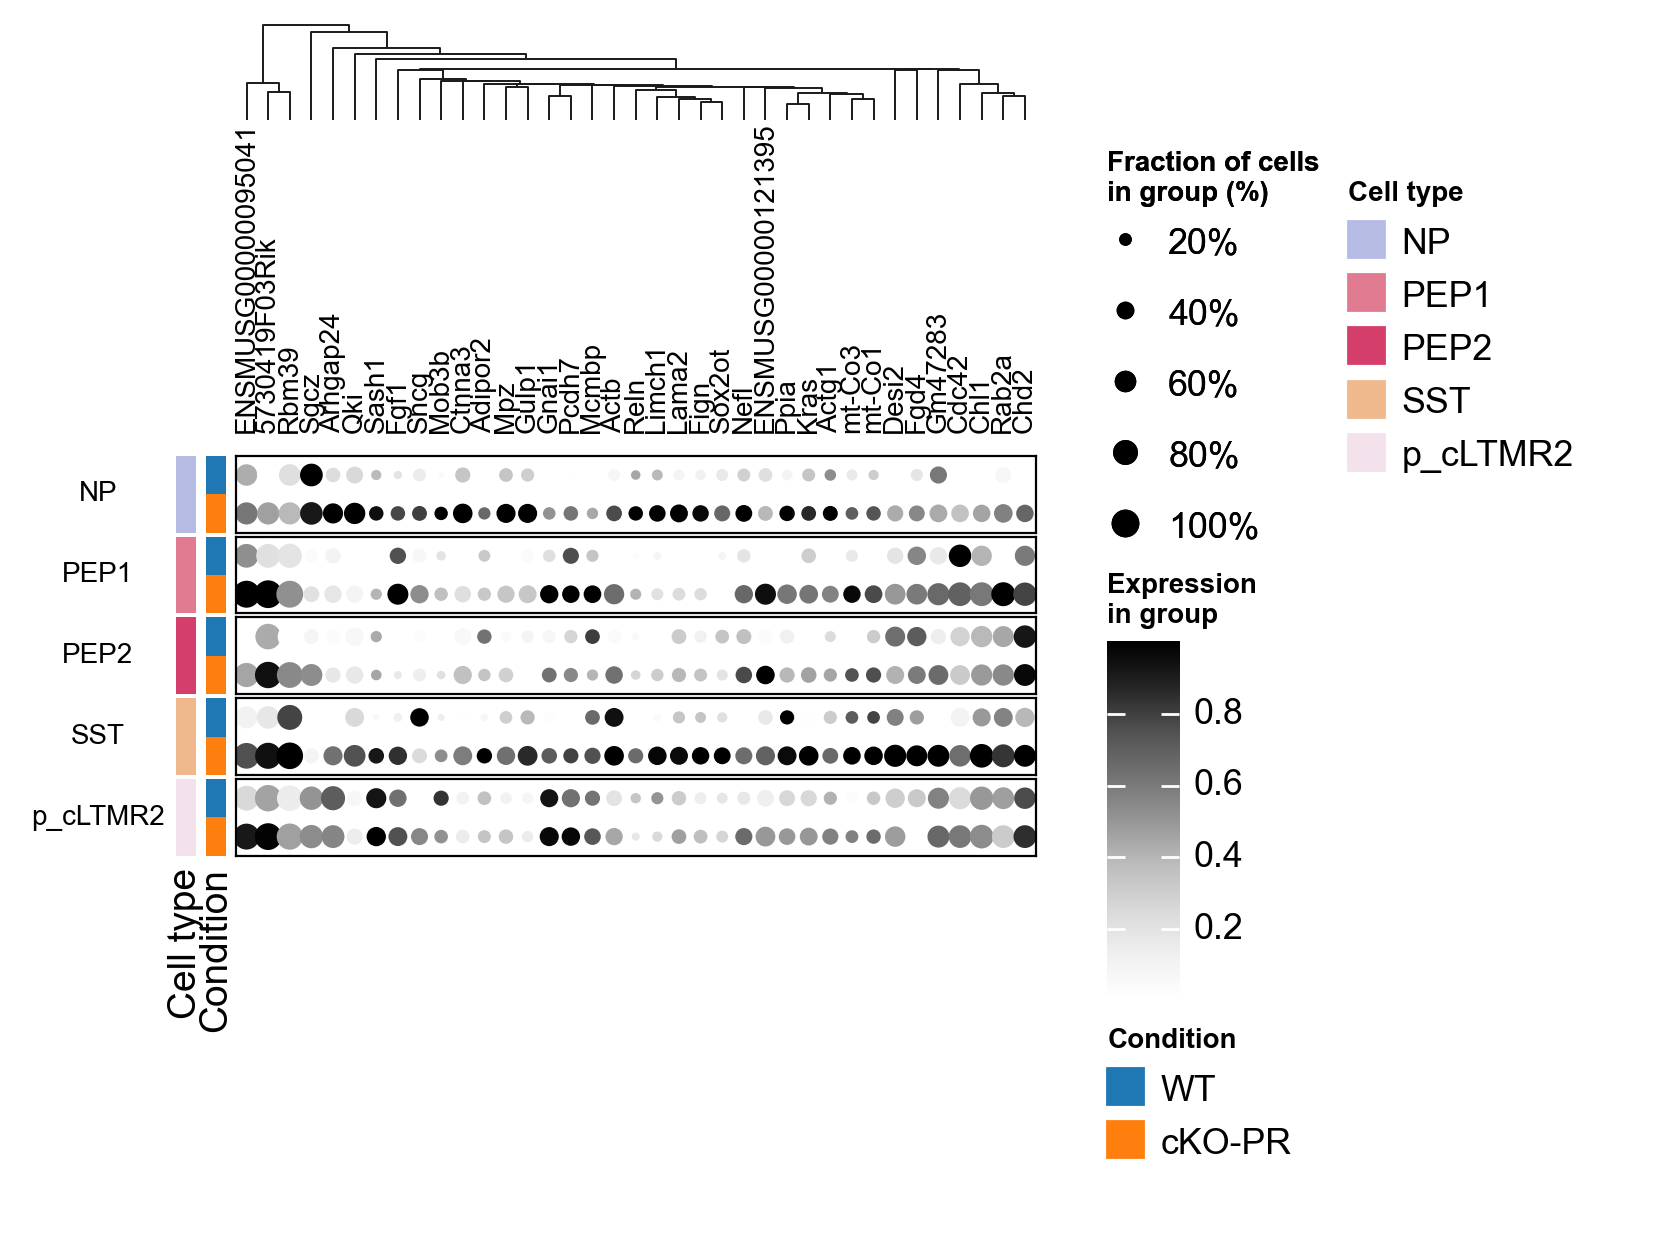

In [ ]:
dx.pl.dotplot(
    adata_noci,
    markers=common_up_genes,
    groupby=['ct_cleaned', 'Conditions'],
    group_names=["Cell type", "Condition"],
    row_grouping=['ct_cleaned'],
    column_grouping=True,
    dendrograms=["top"],
    cmap="Greys",
    scale=True,
    width=4,
    height=2,
    show_legends=True,
    show_column_names=True,
    show_row_names=True,
    save="./figures/11_10x_pbulk_up_markers_dotplot.pdf"
)

2025-10-15 13:42:33 | [INFO] maxp pruned
2025-10-15 13:42:33 | [INFO] LTSH dropped
2025-10-15 13:42:33 | [INFO] cmap pruned
2025-10-15 13:42:33 | [INFO] kern dropped
2025-10-15 13:42:33 | [INFO] post pruned
2025-10-15 13:42:33 | [INFO] PCLT dropped
2025-10-15 13:42:33 | [INFO] JSTF dropped
2025-10-15 13:42:33 | [INFO] DSIG dropped
2025-10-15 13:42:33 | [INFO] GPOS pruned
2025-10-15 13:42:33 | [INFO] GSUB pruned
2025-10-15 13:42:33 | [INFO] glyf pruned
2025-10-15 13:42:33 | [INFO] Added gid0 to subset
2025-10-15 13:42:33 | [INFO] Added first four glyphs to subset
2025-10-15 13:42:33 | [INFO] Closing glyph list over 'GSUB': 27 glyphs before
2025-10-15 13:42:33 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'a', 'c', 'd', 'e', 'f', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'p', 'parenleft', 'parenright', 'percent', 'r', 's', 'space', 't', 'u', 'x', 'y']
2025-10-15 13:42:33 | [INFO] Glyph IDs:   [0, 1, 2, 3, 8, 11, 12, 38, 40, 41, 68, 70, 71, 72, 73, 74, 76, 79, 81, 82, 83, 8

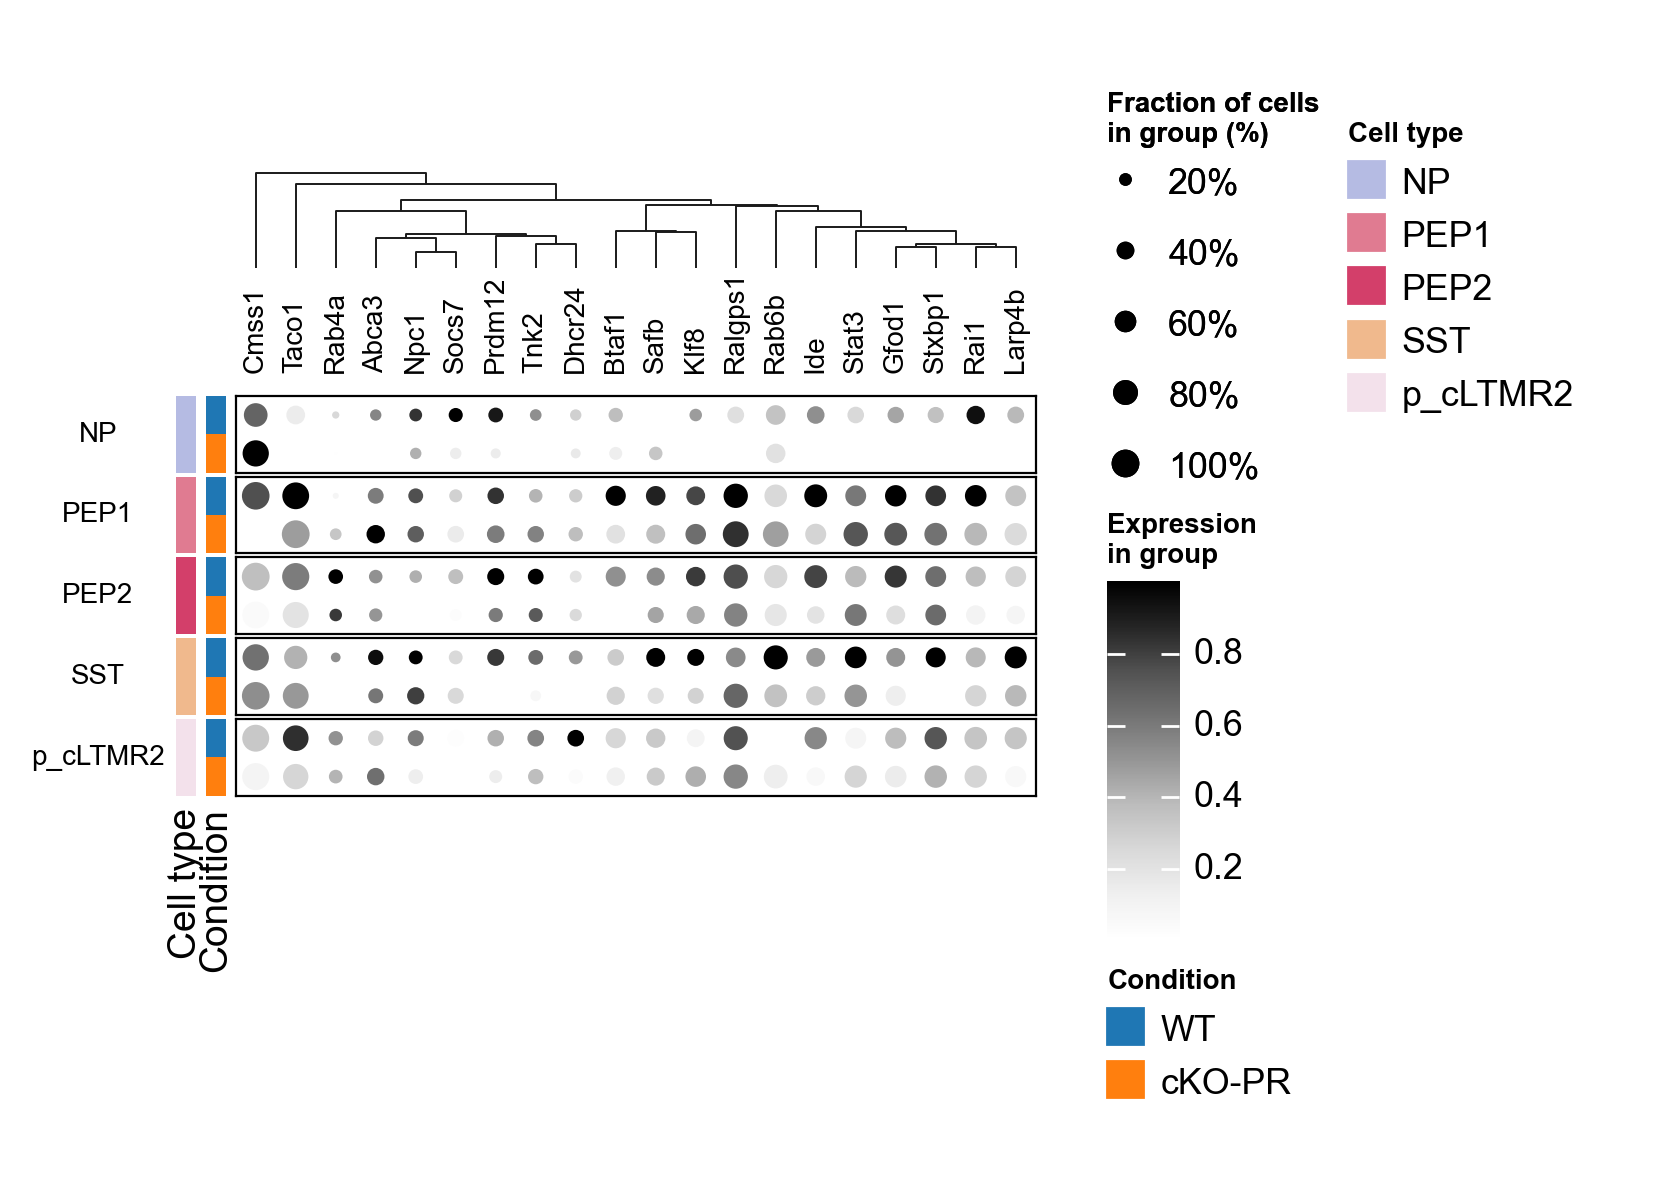

In [ ]:
dx.pl.dotplot(
    adata_noci,
    markers=common_dw_genes,
    groupby=['ct_cleaned', 'Conditions'],
    group_names=["Cell type", "Condition"],
    row_grouping=['ct_cleaned'],
    column_grouping=True,
    dendrograms=["top"],
    cmap="Greys",
    scale=True,
    width=4,
    height=2,
    show_legends=True,
    show_column_names=True,
    show_row_names=True,
    save="./figures/11_10x_pbulk_dw_markers_dotplot.pdf"
)

In [15]:
# Run enrichment
enr_results = dx.tl.de_enrichment_analysis(results, cutoff=0.05, collection="go")
enr_results = enr_results.rename(columns={"group": 'ct_cleaned'})

In [16]:
enr_plot = enr_results[enr_results.Term.str.startswith('GOBP')]
enr_plot.Term = enr_plot.Term.str.split('_').str[1:].str.join('_')

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_19605/2035067212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enr_plot.Term = enr_plot.Term.str.split('_').str[1:].str.join('_')


In [17]:
enr_plot = enr_plot.assign(percent_genes = enr_plot.Overlap.str.split('/').apply(lambda x: float(x[0]) / float(x[1])))

In [ ]:
enr_plot.to_excel('./tables/11_pseudobulk_pydeseq2_cKO-PR_vs_WT_by_ct_gsea.xlsx', index=False)

In [ ]:
enr_plot = pd.read_excel('./tables/11_pseudobulk_pydeseq2_cKO-PR_vs_WT_by_ct_gsea.xlsx')

/Users/pax/miniconda3/envs/rnase4_10x/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  func(*args, **kwargs)
/Users/pax/miniconda3/envs/rnase4_10x/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


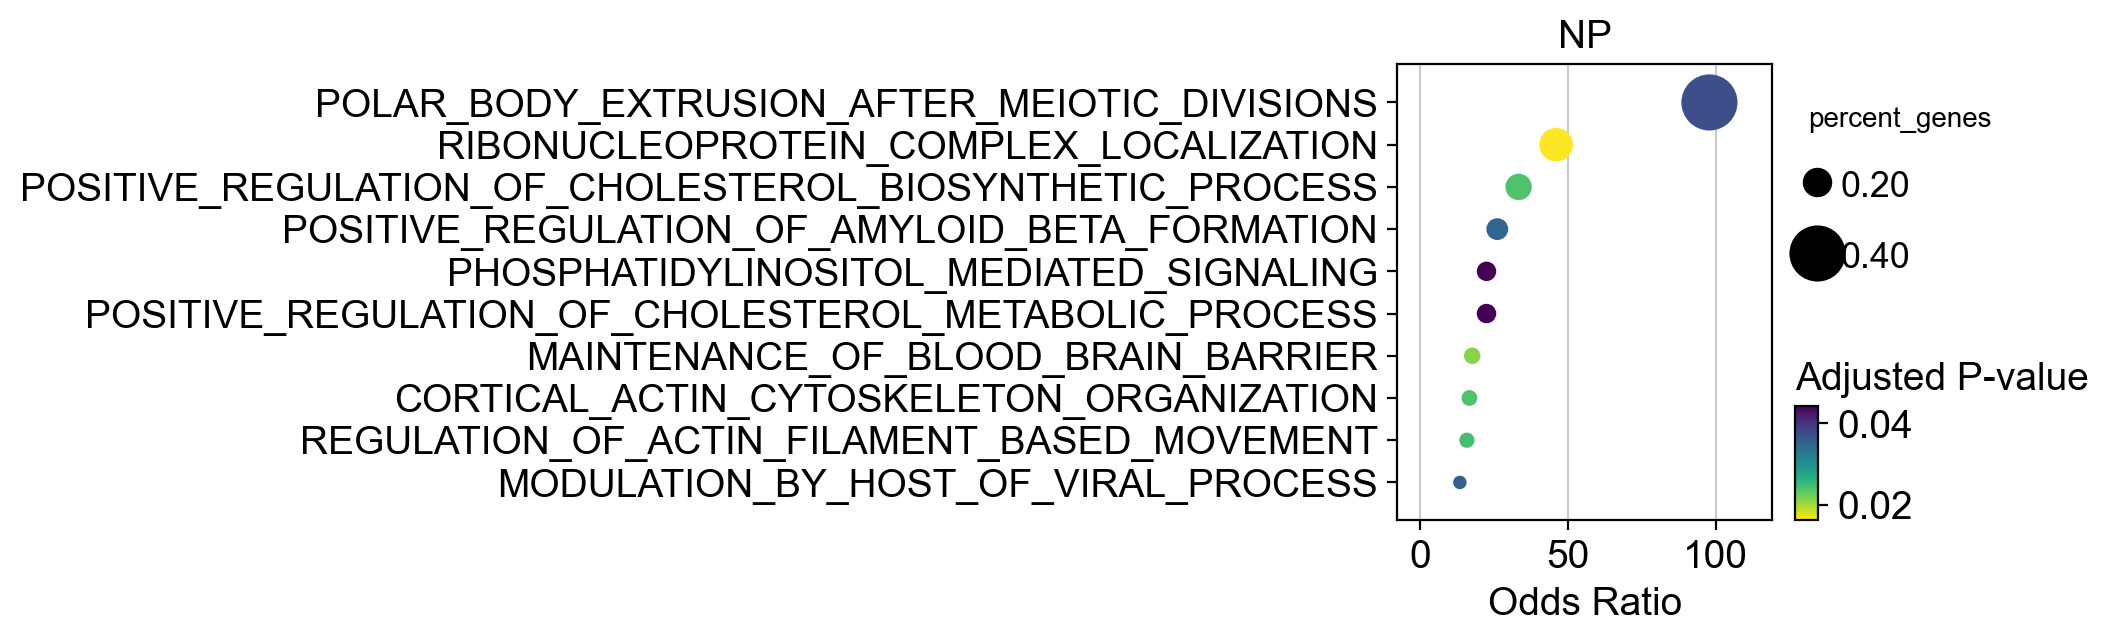

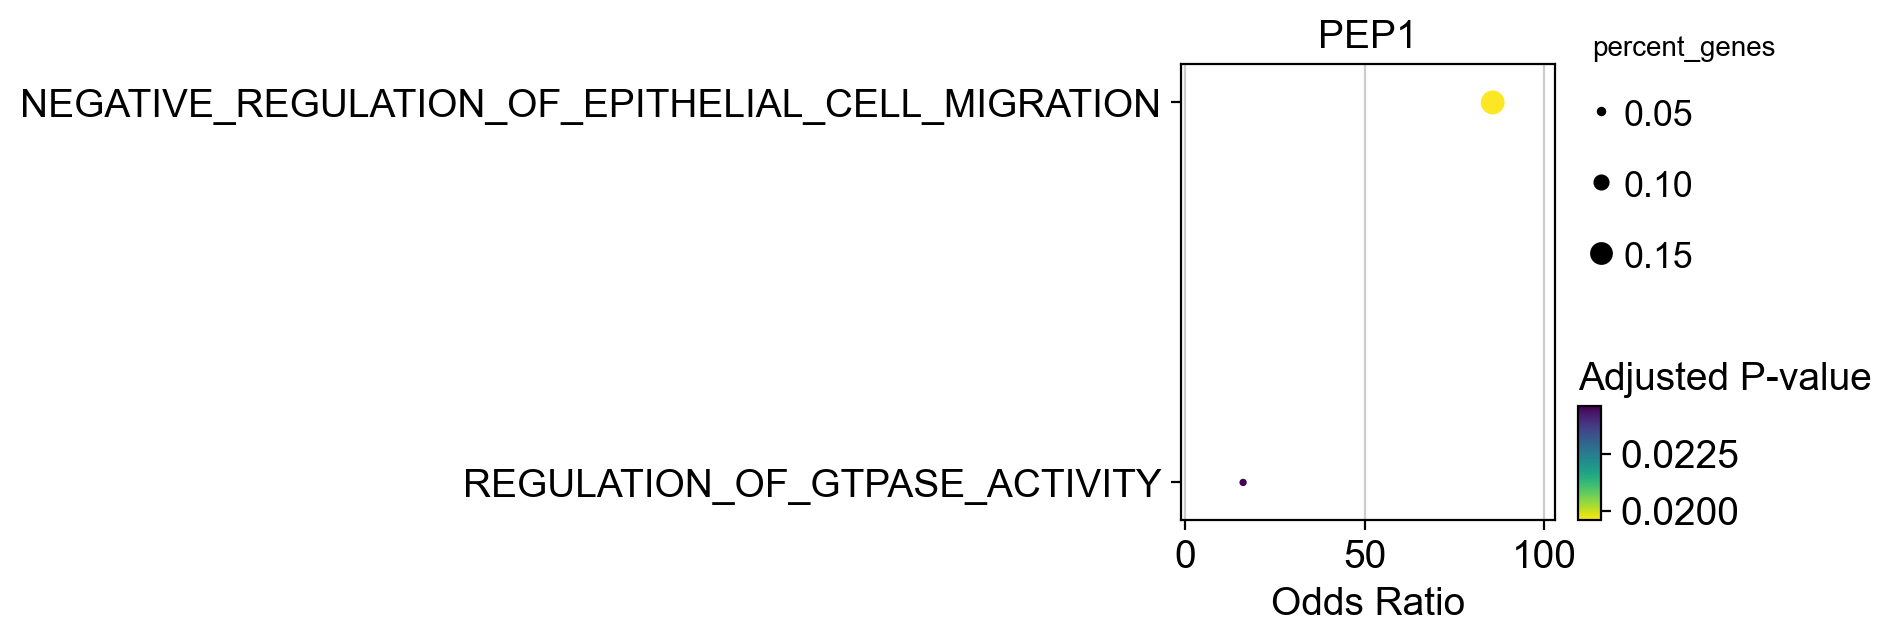

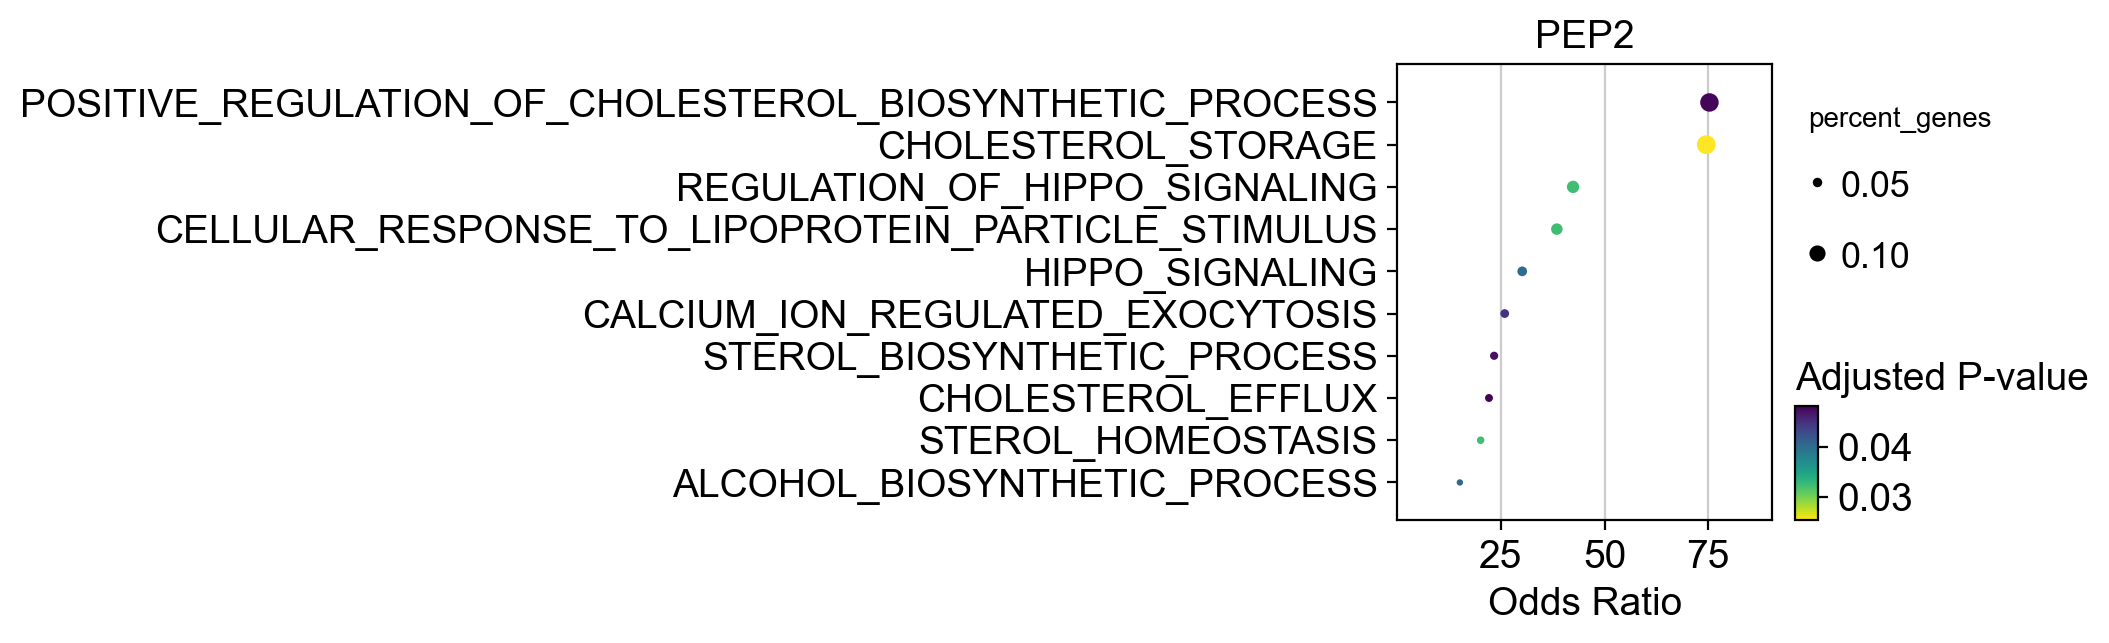

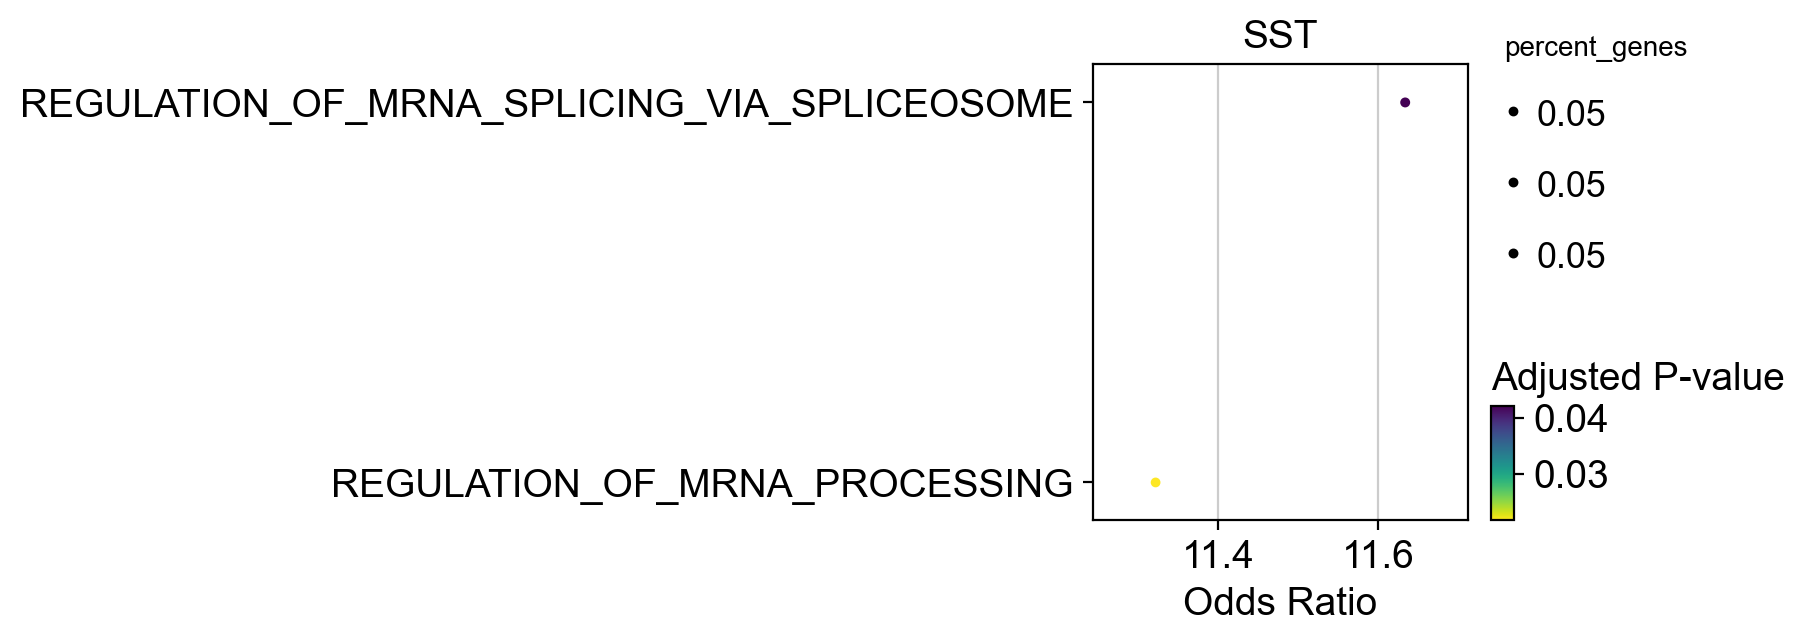

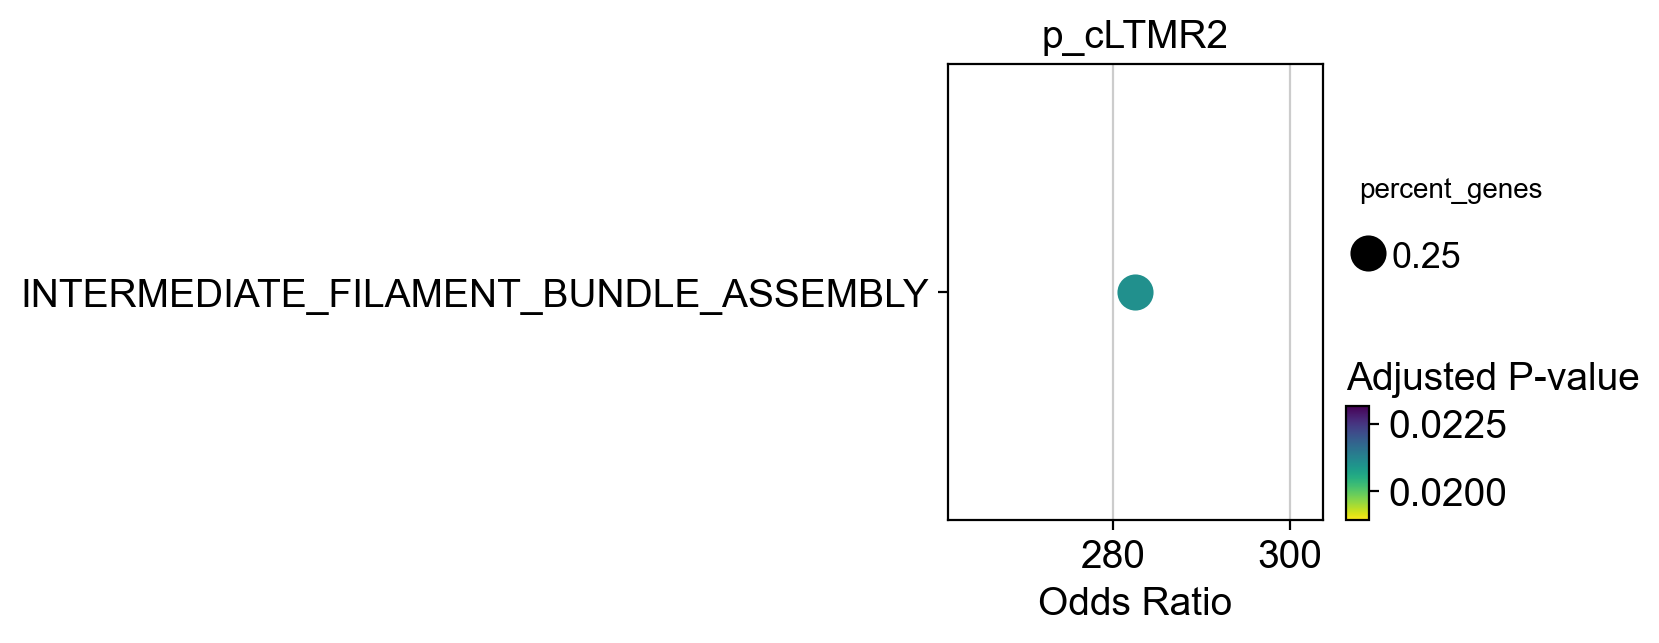

In [123]:
for i, ct in enumerate(enr_plot.ct_cleaned.unique()):
    fig = dc.pl.dotplot(enr_plot[enr_plot.ct_cleaned == ct],
                       x='Odds Ratio',y='Term',s='percent_genes',c='Adjusted P-value',
                       scale=8, cmap='viridis_r',figsize=(3,3), return_fig=True)
    plt.title(ct)

2025-12-18 16:07:28 | [INFO] maxp pruned
2025-12-18 16:07:28 | [INFO] LTSH dropped
2025-12-18 16:07:28 | [INFO] cmap pruned
2025-12-18 16:07:28 | [INFO] kern dropped
2025-12-18 16:07:28 | [INFO] post pruned
2025-12-18 16:07:28 | [INFO] PCLT dropped
2025-12-18 16:07:28 | [INFO] JSTF dropped
2025-12-18 16:07:28 | [INFO] DSIG dropped
2025-12-18 16:07:28 | [INFO] GPOS pruned
2025-12-18 16:07:28 | [INFO] GSUB pruned
2025-12-18 16:07:28 | [INFO] glyf pruned
2025-12-18 16:07:28 | [INFO] Added gid0 to subset
2025-12-18 16:07:28 | [INFO] Added first four glyphs to subset
2025-12-18 16:07:28 | [INFO] Closing glyph list over 'GSUB': 21 glyphs before
2025-12-18 16:07:28 | [INFO] Glyph names: ['.notdef', '.null', 'O', 'R', 'a', 'd', 'g', 'hyphen', 'i', 'j', 'l', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 's', 'space', 't', 'zero']
2025-12-18 16:07:28 | [INFO] Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 19, 20, 50, 53, 68, 71, 74, 76, 77, 79, 82, 83, 86, 87]
2025-12-18 16:07:28 | [INF

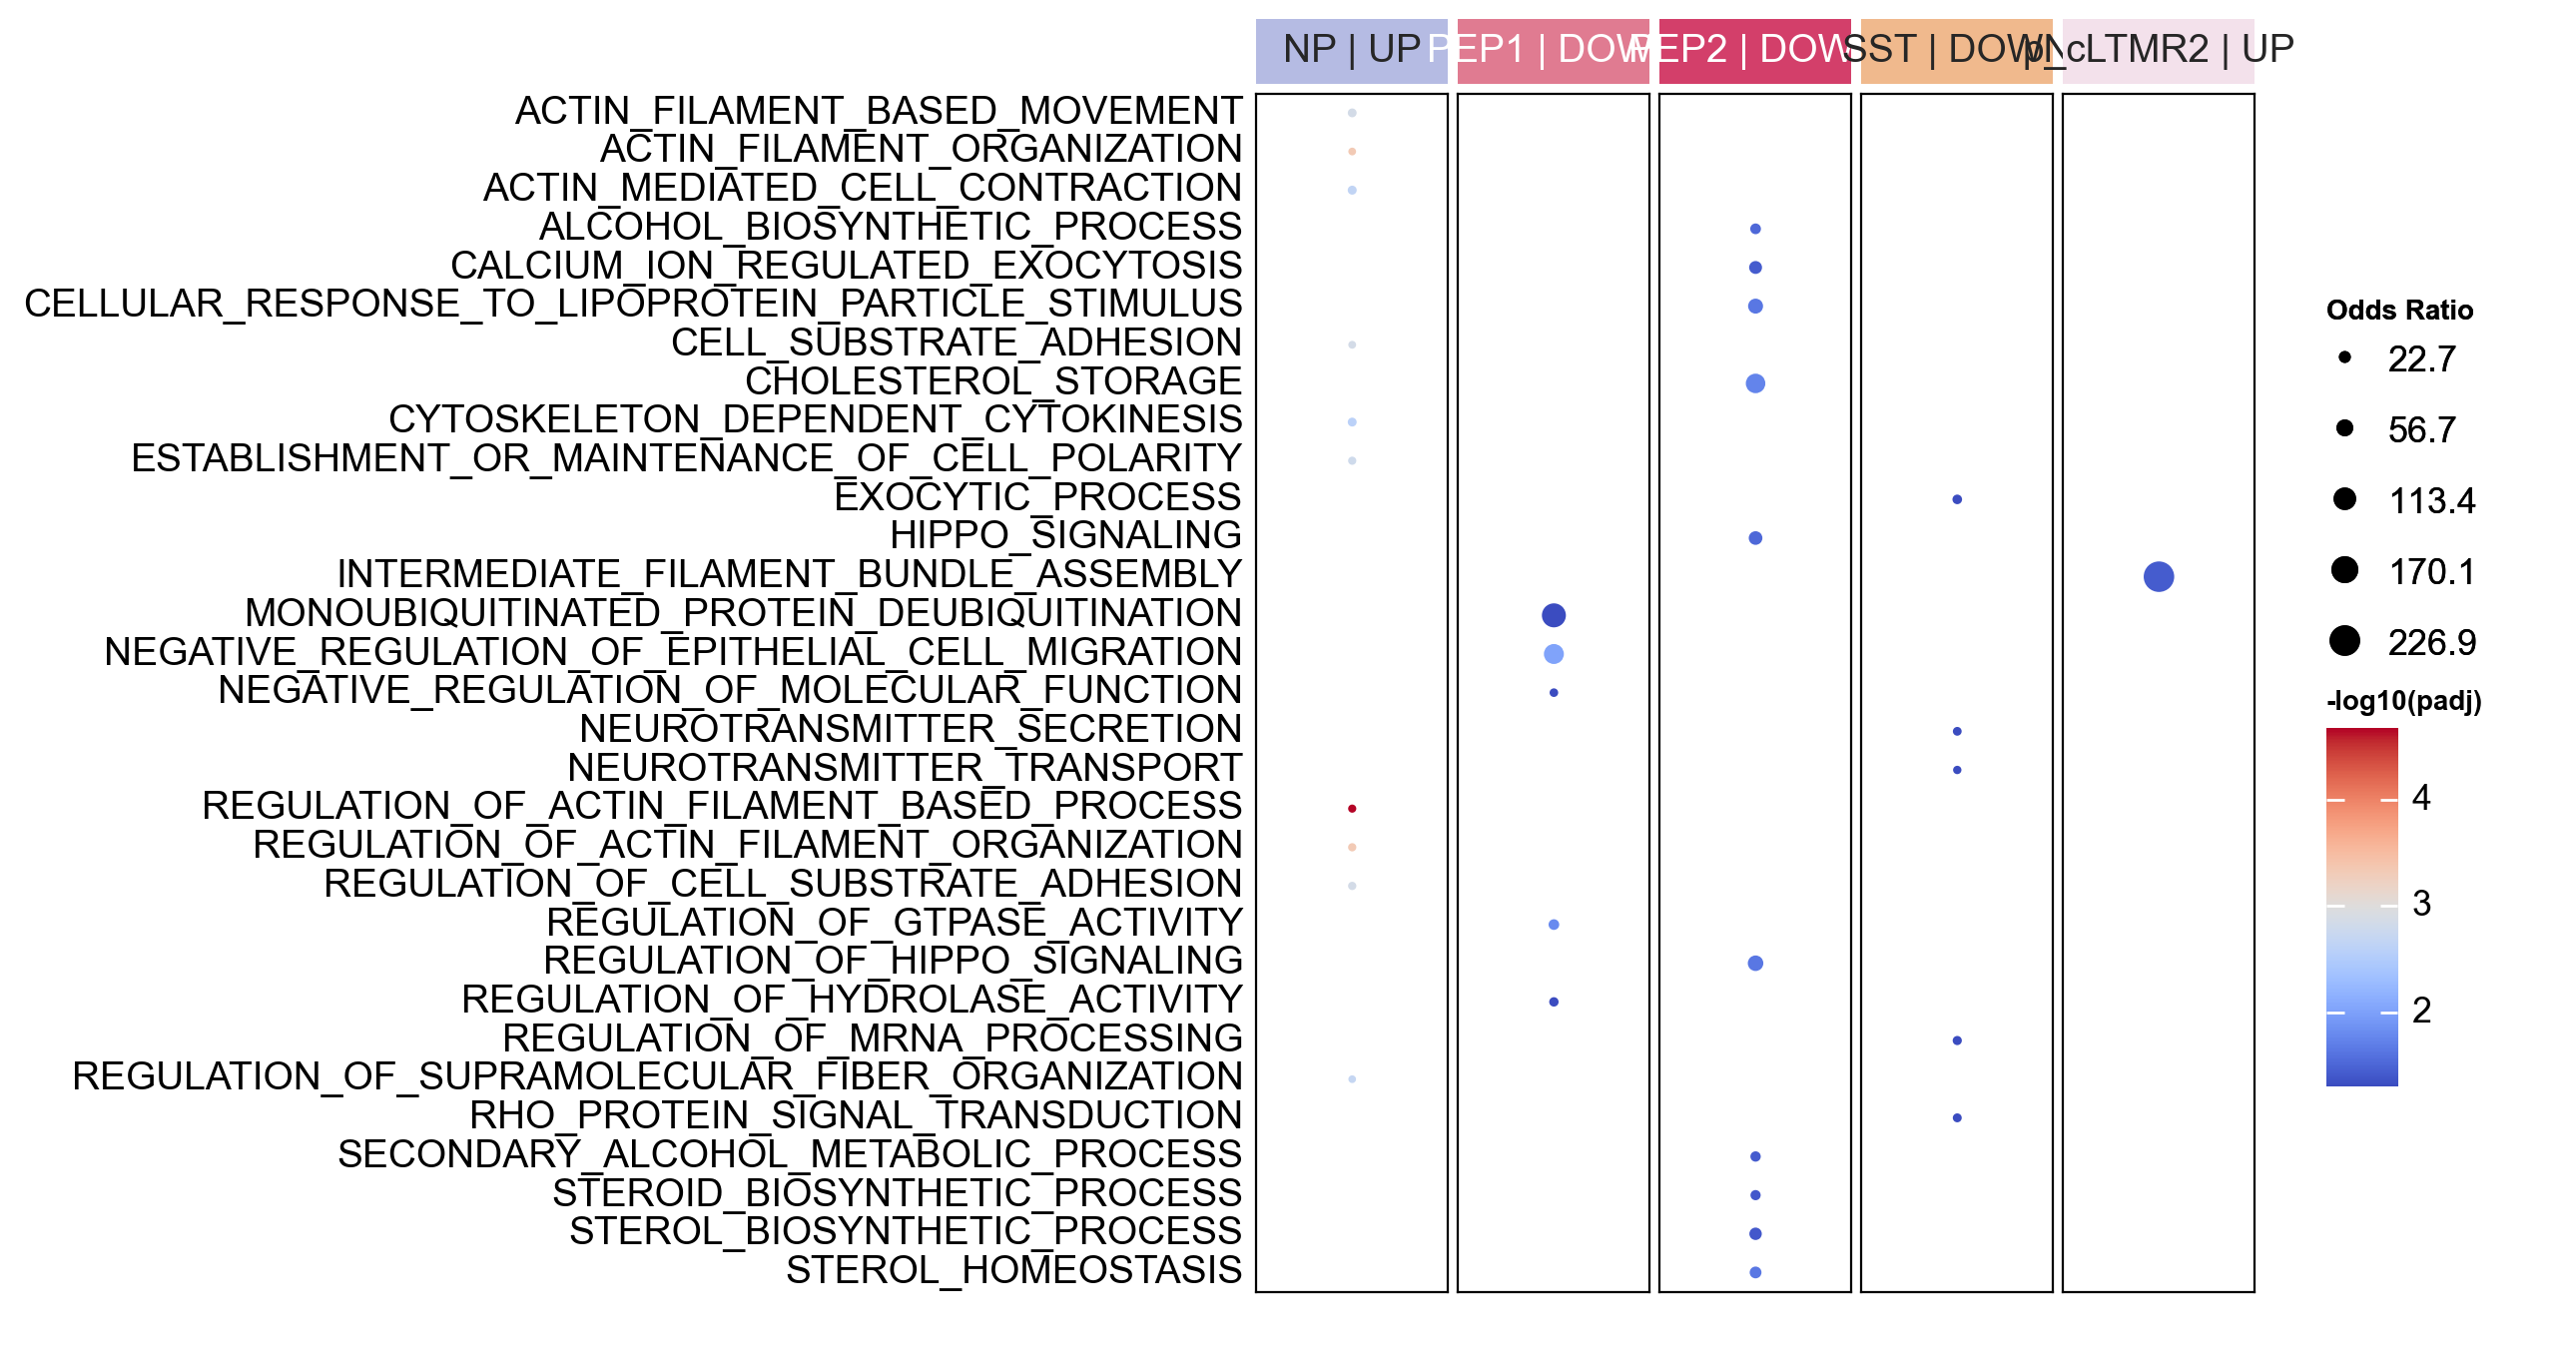

In [ ]:
dx.pl.gsea_dotplot(enr_plot, group_key=["ct_cleaned", "up_dw"], adata=adata_noci, top_n=10, figsize=(5, 6))
plt.savefig(f'./figures/11_10x_pbulk_cKO_vs_ctr_gsea_by_ct.pdf', bbox_inches='tight', dpi=300)

In [ ]:
markers = ['Kcnc2','Kcnma1','Runx1','Trpv1']

/Users/pax/miniconda3/envs/rnase4_10x/lib/python3.11/site-packages/anndata/_core/anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'Nociceptors' as categorical
2025-11-29 16:59:49 | [INFO] maxp pruned
2025-11-29 16:59:49 | [INFO] LTSH dropped
2025-11-29 16:59:49 | [INFO] cmap pruned
2025-11-29 16:59:49 | [INFO] kern dropped
2025-11-29 16:59:49 | [INFO] post pruned
2025-11-29 16:59:49 | [INFO] PCLT dropped
2025-11-29 16:59:49 | [INFO] JSTF dropped
2025-11-29 16:59:49 | [INFO] DSIG dropped
2025-11-29 16:59:49 | [INFO] GPOS pruned
2025-11-29 16:59:49 | [INFO] GSUB pruned
2025-11-29 16:59:49 | [INFO] glyf pruned
2025-11-29 16:59:49 | [INFO] Added gid0 to subset
2025-11-29 16:59:49 | [INFO] Added first four glyphs to subset
2025-11-29 16:59:49 | [INFO] Closing glyph list over 'GSUB': 28 glyphs before
2025-11-29 16:59:49 | [INFO] Glyph names: ['.notdef', '.null', 'E', 'K', 'L', 'M', 'N', 'P', 'R', '

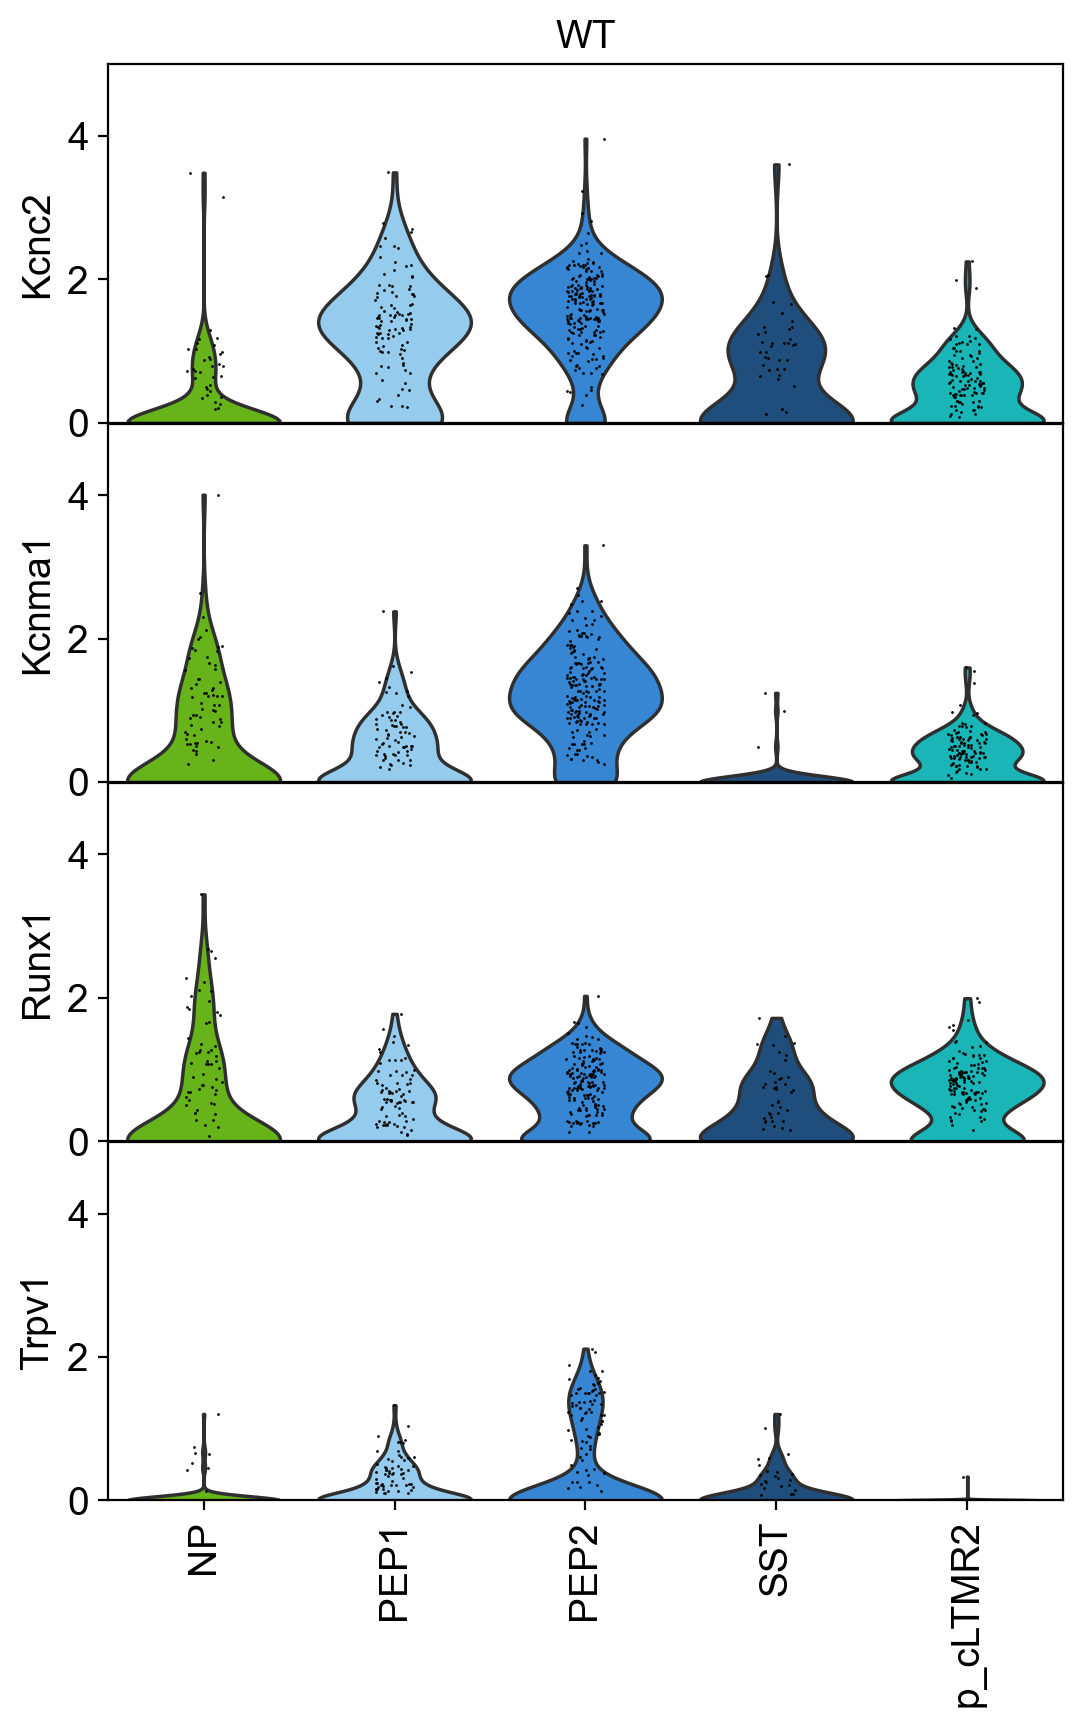

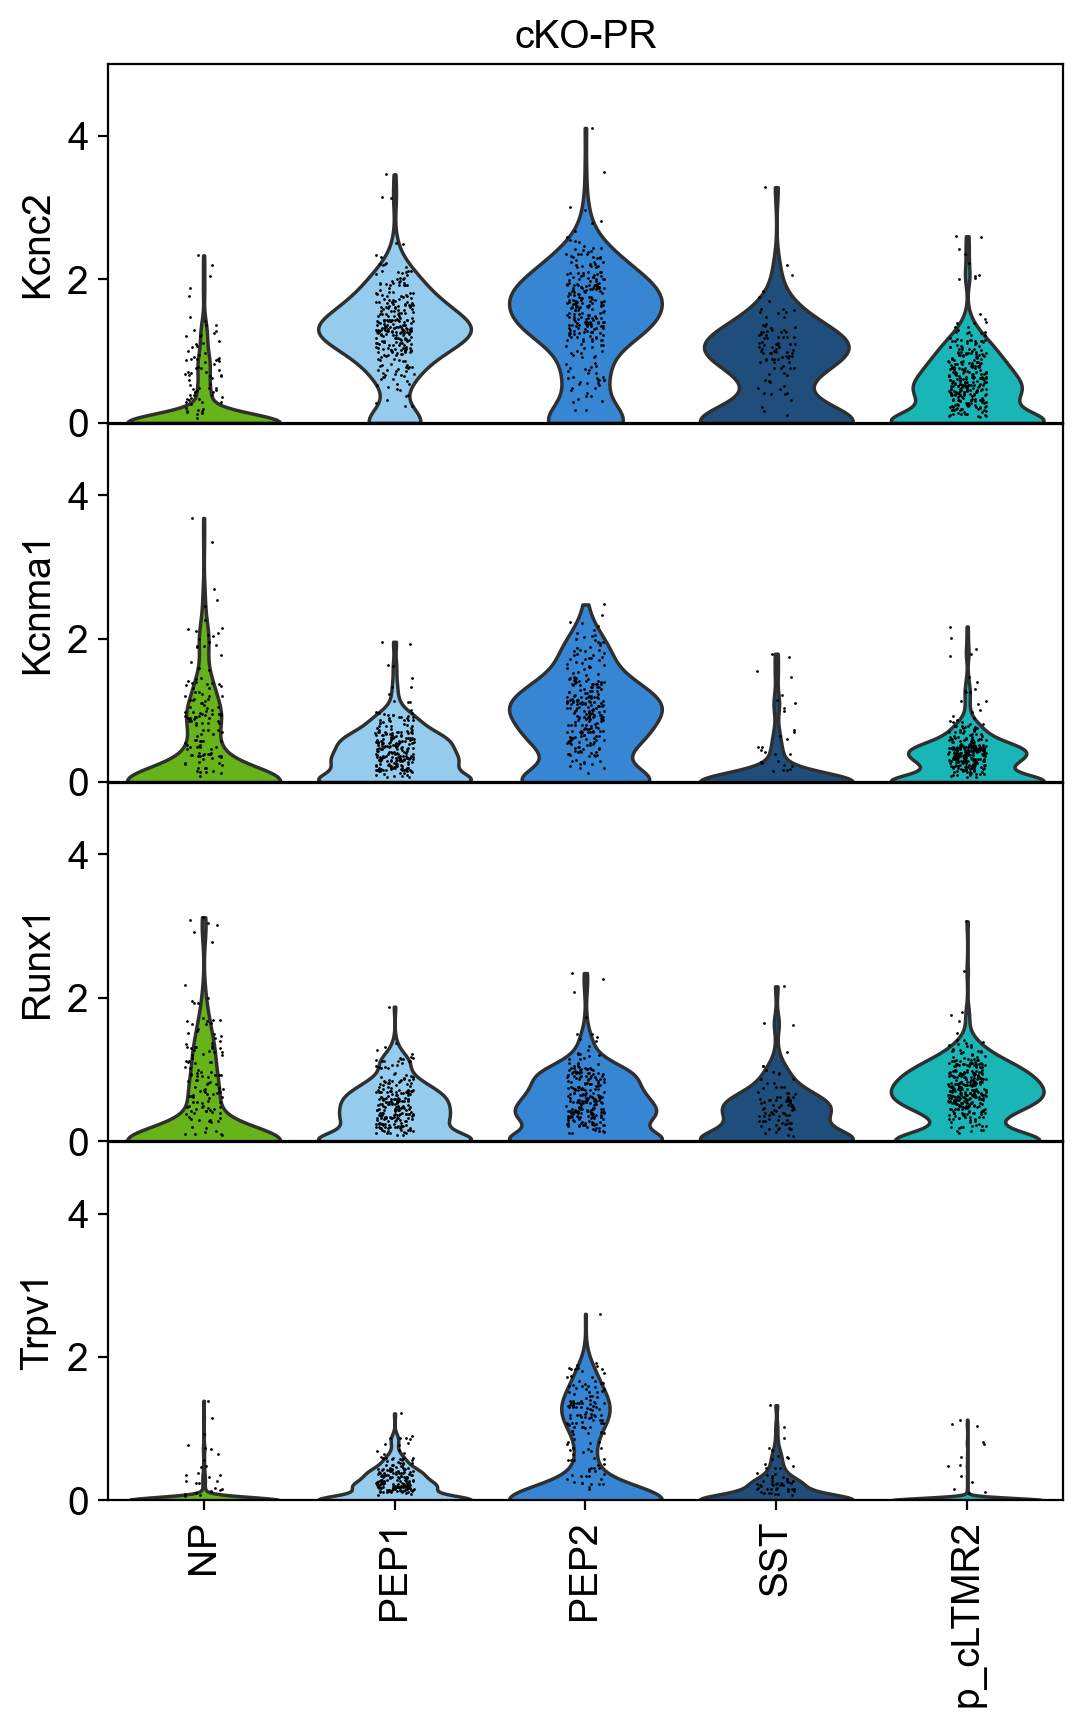

In [ ]:
for s in adata_noci.obs.Conditions.cat.categories:
    fig, ax = stack_vln(adata_noci[adata_noci.obs.Conditions == s], markers, groupby='ct_cleaned', layer=None, stripplot=True, jitter=True, rotation=90, pad=-0.55, palette=sk_color)
    ax[0].set_title(s)
    fig.savefig(f'./figures/11_violin_{s}_markers.pdf', bbox_inches='tight')